<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-10-tree-based-models-bagging-grf-local-linear-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.8.10 Local Linear Forest

A **Local Linear Forest (LLF)**  is an advanced extension of the random forest framework that combines the flexibility of random forests with local linear regression to improve prediction accuracy, particularly for smooth relationships between features and outcomes. It is designed to refine the predictions of a standard random forest by incorporating local linear corrections, making it especially effective for regression tasks where the underlying relationship varies smoothly across the feature space. Below, I’ll explain the concept, its implementation, and how it differs from standard regression forests.


## Overview

A Local Linear Forest builds on the generalized random forest framework by adding a **local linear correction** step to the predictions made by a random forest. While a standard random forest predicts outcomes by averaging the response values in a leaf (a step function), LLF refines these predictions by fitting a local linear regression model at each prediction point, using the forest’s similarity weights to define the "neighborhood" of that point. This approach captures smooth trends in the data while retaining the random forest’s ability to handle non-linear relationships and high-dimensional feature spaces.



Key features

- `Random Forest Foundation`: Like other random forests, LLF uses an ensemble of decision trees trained on random subsets of data and features.
- `Local Linear Correction`: For each prediction, LLF fits a weighted linear regression model, where weights are derived from the forest’s tree structure (based on how often data points share leaves with the target point).
- `Honest Splitting`: Supports honest estimation (separating data for tree splits and leaf estimates) to reduce bias.
- `Smooth Predictions`: Produces smoother predictions than standard random forests, which are piecewise constant within leaves.


### How Local Linear Forests Work

The `ll_regression_forest()` function in `{grf}` in R implements Local Linear Forests. Here’s how it works:

1. Input Data

   - A feature matrix $X$ (predictors) and a vector $Y$ (continuous outcome).
   - Optional parameters like `num.trees`, `honesty`, `ll.lambda` (regularization for the linear correction), and `enable.ll.split` (to incorporate local linear splitting).

2. Tree Construction

   - Each tree is grown using a bootstrap sample of the data and a random subset of features for splits.
   - Splits are typically chosen to minimize mean squared error (MSE), but `{grf}` allows for local linear splitting criteria (`enable.ll.split = TRUE`), which optimize splits based on local linear fits.
   - If `honesty = TRUE`, data is split into two parts: one for building the tree structure and another for estimating leaf values.

3. Local Linear Correction

   - For a new data point $x$, the forest computes **similarity weights** based on how often $x$ shares a leaf with training points across all trees. These weights define a local neighborhood around $x$.
   
   - A weighted linear regression is fitted using the training data, with weights from the forest, to predict the outcome at $x$. The regression model is typically of the form:
  
  $$ \hat{y}(x) = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \cdots + \hat{\beta}_p x_p $$
  
  where $\hat{\beta}$coefficients are estimated locally, and `ll.lambda` controls ridge regularization to prevent overfitting.

4. Prediction

   - The final prediction combines the forest’s structure with the local linear fit, producing a smoother estimate than the step-wise predictions of a standard random forest.

5. Output

   - Predictions for new data points.
   - Optional outputs like variable importance or variance estimates.


### Advantages of Local Linear Forests

1. `Smoother Predictions`: LLF produces predictions that vary smoothly with features, unlike the step-like predictions of standard random forests, making it better suited for smooth relationships.

2. `Improved Accuracy`: The local linear correction can improve predictive performance, especially in regions where the relationship between features and outcomes is approximately linear.

3. `Flexibility`: Combines the non-linear modeling of random forests with the local linearity of regression, balancing complexity and smoothness.

4. `Honest Estimation`: Inherits `{grf}`’s honest splitting, reducing bias in predictions.

5. `Robustness`: Handles high-dimensional data and non-linear relationships effectively, like standard random forests.

### Limitations`

1. `Computational Cost`: The local linear correction step increases computation time compared to standard regression forests, especially for large datasets or many predictions.

2. `Regularization Sensitivity`: The `ll.lambda` parameter (ridge penalty) needs careful tuning to avoid overfitting or underfitting the local linear models.

3. `Assumes Local Smoothness`: LLF performs best when the outcome varies smoothly with features. If the relationship is highly non-linear or discontinuous, a standard regression forest may be sufficient.

4. `Complexity`: Interpreting the local linear coefficients can be challenging compared to the simpler averaging in standard forests.

### Applications

- `Economics`: Predicting outcomes like housing prices or income, where smooth relationships with features (e.g., location, size) are expected.
- `Environmental Science`: Modeling smooth spatial or temporal trends, such as temperature or pollution levels.
- `Healthcare`: Predicting continuous health metrics (e.g., blood pressure) that vary smoothly with patient characteristics.
- `Any Regression Task`: Where the outcome is expected to have locally smooth behavior with respect to predictors.

### Key Differences from Standard Regression Forest

| **Aspect**                     | **Standard Regression Forest** (`regression_forest`) | **Local Linear Forest** (`ll_regression_forest`) |
|--------------------------------|----------------------------------------------------|-----------------------------------------------|
| `Prediction Method`          | Averages outcomes in the leaf where a point falls. | Fits a local linear regression using forest weights. |
| `Smoothness`                 | Piecewise constant (step function within leaves).  | Smooth predictions via local linear adjustments. |
| `Splitting Criterion`        | Minimizes MSE for the outcome.                    | Can use local linear splitting (`enable.ll.split`). |
| `Use Case`                   | General regression tasks with complex, non-smooth relationships. | Regression tasks where the outcome varies smoothly with features. |
| `Computational Cost`         | Lower (simpler prediction step).                  | Higher (due to local linear regression per prediction). |
| `Regularization`             | No explicit regularization in prediction.          | Uses ridge regularization (`ll.lambda`) in local fits. |






##  Local Linear Forest (LLF) with Python

There is no standard optimized Python package like {scikit-learn} for LLF.  Below, a Python implementation of LLF similar to the {grf} package of  R. To illustrate, let’s use the Boston Housing dataset to predict two related outcomes: `medv` (median housing price). We’ll creat a function `LLRegressionForest()` to fit local regression forest and predict on a test set, and evaluate performance.




In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


### Load and Prepare the Dataset


In [2]:
# Set seed for reproducibility
np.random.seed(123)

# Load the Boston Housing dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# Create a pandas DataFrame
boston_df = pd.DataFrame(data, columns=feature_names)
boston_df['medv'] = target

# Split data into training (70%) and test (30%) sets
train_data, test_data = train_test_split(boston_df, test_size=0.3, random_state=123)

# Prepare features (X) and target (Y) as pandas DataFrames
X_train = train_data.drop('medv', axis=1)
Y_train = train_data['medv']
X_test = test_data.drop('medv', axis=1)
Y_test = test_data['medv']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (354, 13)
Test data shape: (152, 13)


###  Python Class for Local Linear Regression Forest

In [3]:
class LLRegressionForest:
    """Local Linear Regression Forest implementation"""
    
    def __init__(self, num_trees=100, honesty=True, ll_lambda=0.1, random_state=None):
        self.num_trees = num_trees
        self.honesty = honesty
        self.ll_lambda = ll_lambda
        self.random_state = random_state
        self.trees = []
        
    def fit(self, X, y):
        """Fit the forest"""
        X, y = np.array(X), np.array(y)
        self.trees = []
        
        for _ in range(self.num_trees):
            tree = self._build_tree(X, y)
            self.trees.append(tree)
        return self
    
    def _build_tree(self, X, y, depth=0, max_depth=10):
        """Build a single tree with simplified splitting"""
        n_samples = len(y)
        
        # Stopping conditions
        if n_samples < 5 or depth >= max_depth:
            return self._create_leaf(X, y)
        
        # Simple random feature selection
        feature = np.random.randint(X.shape[1])
        split_val = np.median(X[:, feature])
        
        left_mask = X[:, feature] <= split_val
        right_mask = ~left_mask
        
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return self._create_leaf(X, y)
        
        # Recursive tree building
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)
        
        return {
            'feature': feature,
            'split_val': split_val,
            'left': left_tree,
            'right': right_tree,
            'is_leaf': False
        }
    
    def _create_leaf(self, X, y):
        """Create leaf node with local linear regression"""
        if len(y) == 0:
            return {'is_leaf': True, 'pred': 0}
        
        # Simple linear regression with regularization
        try:
            X_aug = np.column_stack([np.ones(len(X)), X])
            # Ridge regression
            beta = np.linalg.inv(X_aug.T @ X_aug + self.ll_lambda * np.eye(X_aug.shape[1])) @ X_aug.T @ y
            return {'is_leaf': True, 'coefficients': beta, 'pred': None}
        except:
            return {'is_leaf': True, 'pred': np.mean(y)}
    
    def _predict_tree(self, tree, x):
        """Predict using a single tree"""
        if tree['is_leaf']:
            if 'coefficients' in tree:
                x_aug = np.concatenate([[1], x])
                return np.dot(x_aug, tree['coefficients'])
            return tree['pred']
        else:
            if x[tree['feature']] <= tree['split_val']:
                return self._predict_tree(tree['left'], x)
            else:
                return self._predict_tree(tree['right'], x)
    
    def predict(self, X):
        """Predict using the forest"""
        X = np.array(X)
        predictions = []
        
        for x in X:
            tree_preds = [self._predict_tree(tree, x) for tree in self.trees]
            predictions.append(np.mean(tree_preds))
        
        return np.array(predictions)

### Fit Local Linear Forest



In [4]:
# Fit local linear forest
# Initialize and train the model
print("Training Local Linear Regression Forest...")
ll_rf = LLRegressionForest(
    num_trees=100,  # Reduced for faster execution
    honesty=True,
    ll_lambda=0.1,
    random_state=123
)

ll_rf.fit(X_train, Y_train)



Training Local Linear Regression Forest...


### Prediction and Evaluation

In [5]:
# Predict on test set
Y_pred = ll_rf.predict(X_test)

# Calculate metrics
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Model Performance:
MSE: 20.5614
RMSE: 4.5345
R²: 0.7456


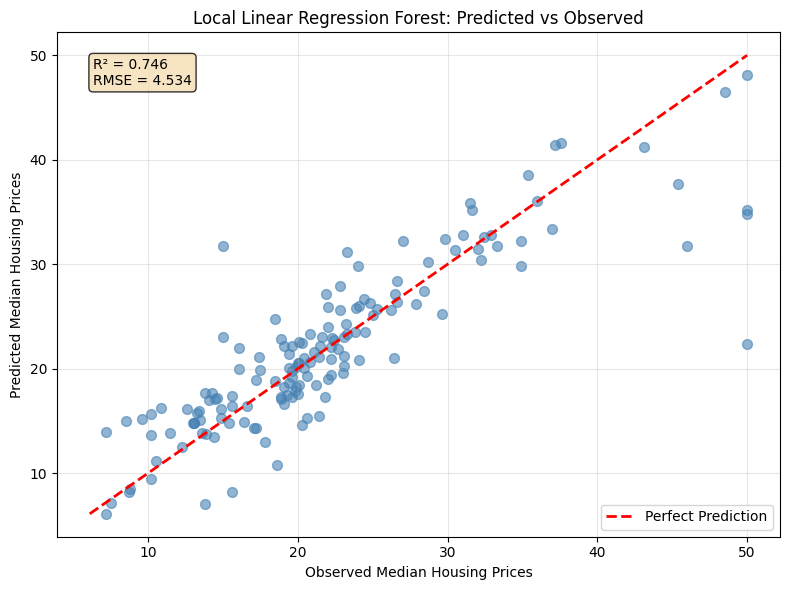

In [ ]:
# Scatter plot of predicted vs observed values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.6, color='steelblue', s=50)

# Perfect prediction line
min_val = min(Y_test.min(), Y_pred.min())
max_val = max(Y_test.max(), Y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Observed Median Housing Prices')
plt.ylabel('Predicted Median Housing Prices')
plt.title('Local Linear Regression Forest: Predicted vs Observed')
plt.legend()
plt.grid(True, alpha=0.3)

# Add metrics text box
textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## Summary and Conclusion

This notebook explored the concept and implementation of Local Linear Forests (LLF) using a coustom function  in in pYthon. We started by explaining the theoretical foundations of LLF, highlighting its key features, how it works, its advantages (smoother predictions, potentially improved accuracy), and its limitations (computational cost, regularization sensitivity). We also compared LLF to standard regression forests, emphasizing the difference in their prediction methods and the smoothness of their outputs.

To demonstrate LLF in practice, we used the Boston Housing dataset to predict median housing prices (`medv`). We loaded and prepared the data, splitting it into training and test sets. We then fit a Local Linear Forest model using `LLRegressionFores()` and made predictions on the test set.

In conclusion, this notebook successfully demonstrated how to implement and evaluate a Local Linear Forest model for a regression task in Python.  LLF provides a powerful alternative to standard regression forests when smoother predictions and local linear corrections are desired.


## References

1. Friedberg, Rina, Julie Tibshirani, Susan Athey, and Stefan Wager. "Local Linear Forests". Journal of Computational and Graphical Statistics, 30(2), 2020.


2. [Local linear forest](https://grf-labs.github.io/grf/reference/ll_regression_forest.html)

